<a href="https://colab.research.google.com/github/YamenZaza/Personal-Projects/blob/master/NYC_CitiTrips_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this short report, I will attempt to answer the following questions based on the NYC Citi Bike data:
- What is the trip duration distribution of Citibike trips?
- What is the most popular Citibike trip?
- Were there new bike stations introduced or removed at any point in time? What makes you think it were or weren't?


Due to storage limitation, not all relevant information can be retrieved using SQL statements. The results are saved and imported to this notebook. The following SQL statement will be used to tackle the first question:
  
SELECT  
  start_station_id AS start_station,  
  end_station_id AS end_station,  
  tripduration AS duration  
FROM  
  `bigquery-public-data.new_york.citibike_trips`

The analysis uses two Python tools only as follows:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

We import our data and take a quick glimpse.

In [ ]:
# Trip duration schema is in seconds while start and end stations are represented by IDs
dt = pd.read_csv("/content/drive/My Drive/bq-results-20200615-213639-yfxy5113kygz/citi_data.csv")
dt['duration'] = dt['duration'] / 60 / 60 # Durations in hours
print("The original total number of enteries as of June 2020 is {}".format(dt.size))
dt.head()

The original total number of enteries as of June 2020 is 99957057


,start_station,duration,end_station
0,387,0.315833,507
1,387,0.579444,501
2,387,0.562778,3002
3,387,0.175833,3002
4,387,0.179167,3002


We start off by cleaning the data we received. To do so, we start by checking for any corrupted values and removing them if present.

In [ ]:
dt.isna().sum() # no NaN values - same result if isnull() is used

start_station    0
duration         0
end_station      0
dtype: int64

We can now move onto removing weird data from our dataset. The Pandas describe method allows us to see that we have huge values for trip durations in minutes. From the official NYC Citi bike website, we find that users who fail to return bikes within 24 hours from initial rental time will be fined $1200 (visited in June 2020).  
  
With the previous information, we try to limit our analysis to trip durations that are less than 24 hours. Trips that surpass that limit will be replaced by the average to ensure that certain pairs of stations dont get removed. This can of course affect the distrubtion; however, since the number of replaced trips is very small compared to the total number of trips it can be thought as still a meaningful approach for the questions.

In [ ]:
data_mean = dt['duration'].describe().transpose()[['min', 'max', 'mean']][2]
print("Range of duration data:")
dt['duration'].describe().transpose()[['min', 'max', 'mean']]

Range of duration data:


min        0.016667
max     1863.203611
mean       0.259375
Name: duration, dtype: float64

In [ ]:
dt_filtered = dt.where(dt['duration'] < (24)).fillna(data_mean)

In order to find the distribution of trip duration, a histogram will be displayed.

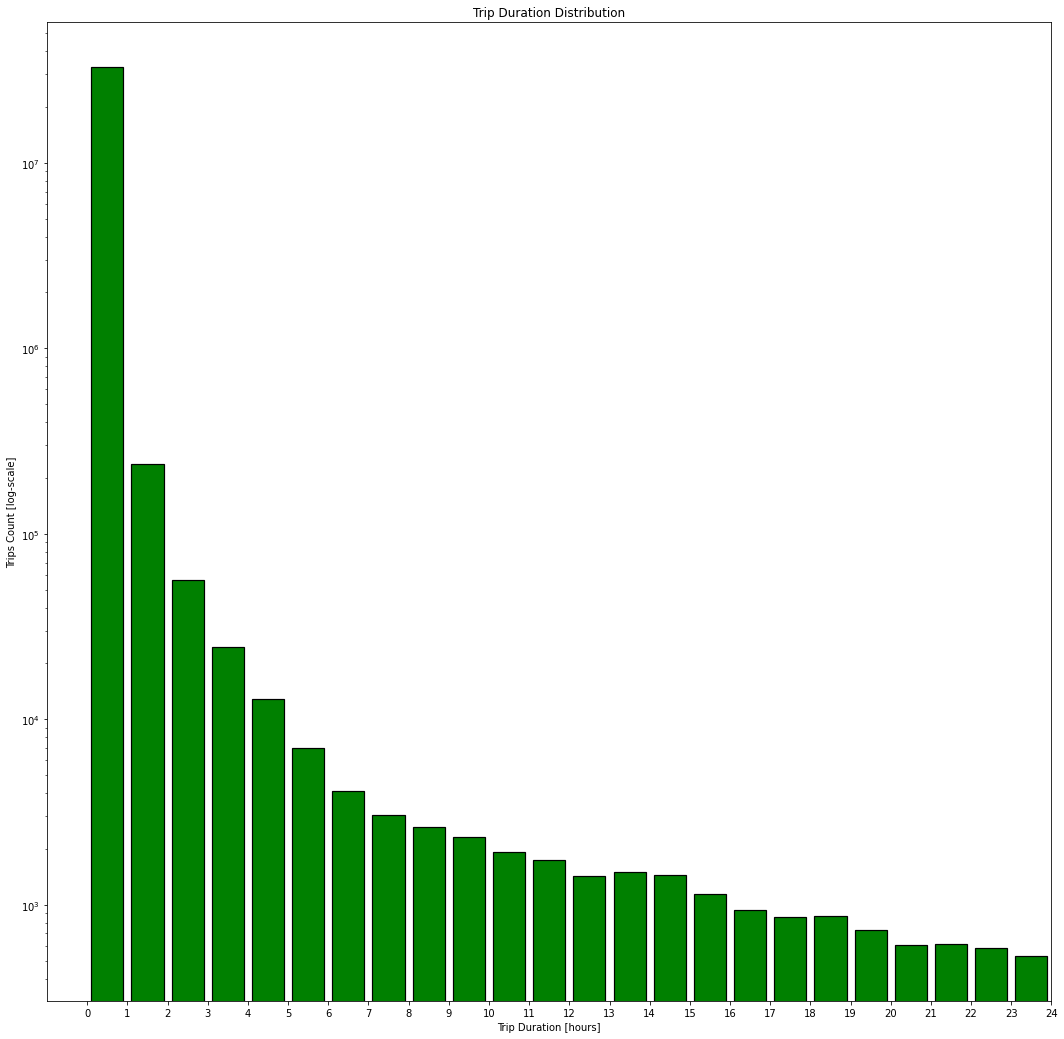

In [ ]:
bins = range(0, 25)
plt.figure(figsize=(18,18))
plt.hist(dt_filtered['duration'], bins = bins, log = True, color = 'green', edgecolor='black', linewidth=1.2, rwidth=0.8)
plt.title("Trip Duration Distribution")
plt.xlabel("Trip Duration [hours]")
plt.ylabel("Trips Count [log-scale]")
plt.xlim(-1, 24)
plt.xticks(range(25))
# plt.savefig('trip_duration_distribution.png') # USE THIS LINE IF IT IS HARD TO SEE THE FIGURE
plt.show()


To answer the second question, a SQL statement is mainly used to get the most popular Citi bike ride between two unique and different stations. The statement is:  
  
SELECT  
  start_station_id,  
  STRING_AGG(start_station_name) AS start_station,  
  end_station_id,  
  STRING_AGG(end_station_name) AS end_station,  
  COUNT(*) AS total_trips  
FROM    
  `bigquery-public-data.new_york.citibike_trips`  
WHERE start_station_id != end_station_id  
GROUP BY  
  start_station_id, end_station_id  
ORDER BY  
  5 DESC  
LIMIT  
  1;  
  


In [ ]:
dt2 = pd.read_csv("/content/drive/My Drive/bq-results-20200616-200305-hgi09l2vasnd/citi_q2.csv")
top_start_station = dt2['start_station'][0].split(',')[0]
top_end_station = dt2['end_station'][0].split(',')[0]
top_total_trips = dt2['total_trips'][0]
print("The most popular Citi bike trip is between '{}' and '{}' with a total of '{}' trips!".format(top_start_station, top_end_station, top_total_trips))

The most popular Citi bike trip is between '12 Ave & W 40 St' and 'West St & Chambers St' with a total of '12417' trips!


To answer the third and final quesiton, we use the following SQL statement and explore the results:  
  
SELECT  
station_id,  
is_installed,  
is_renting,  
is_returning,  
last_reported  
FROM  
`bigquery-public-data.new_york.citibike_stations`  
WHERE  
is_installed AND NOT is_renting AND NOT is_returning  

In [ ]:
dt3 = pd.read_csv("/content/drive/My Drive/bq-results-20200617-231431-16kmbpx8y7oj (1)/citi_q3.csv")
dt3

,station_id,is_installed,is_renting,is_returning,last_reported
0,3416,True,False,False,1970-01-01 00:00:00 UTC
1,3457,True,False,False,1970-01-01 00:00:00 UTC
2,3594,True,False,False,1970-01-01 00:00:00 UTC
3,3476,True,False,False,2018-01-05 16:43:26 UTC
4,3548,True,False,False,1970-01-01 00:00:00 UTC
5,3436,True,False,False,1970-01-01 00:00:00 UTC
6,316,True,False,False,1970-01-01 00:00:00 UTC


A couple of remarks can be made on the results above:  
1- Having last_reported datatimes of the Unix Time (1970-01-01 00:00:00 UTC) can mean that the schema defined this values as the default. Thus we can say that such stations have never reported which can possibly mean that the stations have been recently introduced.

2- The station with id **3476** has not reported in a long time and the results show that it is no longer renting or accepting returns. We can say that this station has possibly been removed from being a public station but its structure is still intact.


Notes:
- Recording errors can affect data retrived negatively by adding fake new stations or trips. This can be further analyzed by drawing a geographical map using the station coordinates to varify that everything makes sense using simple Python packages.
- We can double check the data by doing some web searches to varify the existence of the stations and whether they are operational or not.